In [1]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")

In [2]:
c0=sns.color_palette()[0]
c1=sns.color_palette()[1]
c2=sns.color_palette()[2]

#### Get Data from pickle object

In [3]:
dfWithG=pd.read_pickle('data/dataframe.pkl')

#### Get data for a quater

In [4]:
df1=dfWithG[(dfWithG['year']==2013) & (dfWithG['quarter']==4)]
df1=dfWithG.groupby('LOAN SEQUENCE NUMBER').max()

In [5]:
df1['NON-PERFORMING']=['Y' if x>0 else 'N' for x in df1['CURRENT LOAN DELINQUENCY STATUS']]

In [6]:
df1.head()

,MONTHLY REPORTING PERIOD,CURRENT ACTUAL UPB,CURRENT LOAN DELINQUENCY STATUS,REMAINING MONTHS TO LEGAL MATURITY,REPURCHASE FLAG,MODIFICATION FLAG,CURRENT INTEREST RATE,CURRENT DEFERRED UPB,year,quarter,CREDIT SCORE,FIRST TIME HOMEBUYER FLAG,MORTGAGE INSURANCE PERCENTAGE,CLTV,DTI Ratio,change-current,change-chained,NON-PERFORMING
LOAN SEQUENCE NUMBER,,,,,,,,,,,,,,,,,,
F199Q1000002,2011-11-01,99584.031250,0,247,N,N,6.300,0.0,2011,4,733,N,000,51.0,0.0,5.9,4.9,N
F199Q1000016,2010-06-01,192371.562500,0,242,N,N,6.000,0.0,2010,4,738,N,000,73.0,44.0,5.8,3.9,N
F199Q1000019,2010-04-01,69339.007812,0,242,N,N,6.125,0.0,2010,4,760,N,000,63.0,30.0,5.8,3.9,N
F199Q1000020,2011-09-01,77741.156250,0,242,N,N,6.000,0.0,2011,4,788,N,000,73.0,38.0,5.9,3.9,N
F199Q1000021,2009-06-01,128044.468750,0,242,N,N,6.125,0.0,2009,2,516,N,000,78.0,48.0,-1.1,-0.4,N


In [7]:
df1=df1.reset_index()

In [8]:
print(len(df1))
dtest=df1[df1["NON-PERFORMING"]=='Y']
print (len(dtest))
#dtest.head()

37052
7369


In [9]:
df1.head()

,LOAN SEQUENCE NUMBER,MONTHLY REPORTING PERIOD,CURRENT ACTUAL UPB,CURRENT LOAN DELINQUENCY STATUS,REMAINING MONTHS TO LEGAL MATURITY,REPURCHASE FLAG,MODIFICATION FLAG,CURRENT INTEREST RATE,CURRENT DEFERRED UPB,year,quarter,CREDIT SCORE,FIRST TIME HOMEBUYER FLAG,MORTGAGE INSURANCE PERCENTAGE,CLTV,DTI Ratio,change-current,change-chained,NON-PERFORMING
0,F199Q1000002,2011-11-01,99584.031250,0,247,N,N,6.300,0.0,2011,4,733,N,000,51.0,0.0,5.9,4.9,N
1,F199Q1000016,2010-06-01,192371.562500,0,242,N,N,6.000,0.0,2010,4,738,N,000,73.0,44.0,5.8,3.9,N
2,F199Q1000019,2010-04-01,69339.007812,0,242,N,N,6.125,0.0,2010,4,760,N,000,63.0,30.0,5.8,3.9,N
3,F199Q1000020,2011-09-01,77741.156250,0,242,N,N,6.000,0.0,2011,4,788,N,000,73.0,38.0,5.9,3.9,N
4,F199Q1000021,2009-06-01,128044.468750,0,242,N,N,6.125,0.0,2009,2,516,N,000,78.0,48.0,-1.1,-0.4,N


####  Get both two set of data with flag Y and N of equal size and merge them

In [10]:
dfNP=df1[df1["NON-PERFORMING"]=='Y']
dfP=df1[df1["NON-PERFORMING"]=='N']

In [11]:
dfNP=dfNP.sample(n=7000)
dfP=dfP.sample(n=7000)

In [12]:
print(len(dfNP))
print (len(dfP))

7000
7000


In [13]:
df1=dfNP.append(dfP)

In [14]:
print(len(df1))

14000


#### CV_SCORE function that uses KFold functions to split data in n fold and averages the score .

In [15]:
from sklearn.cross_validation import KFold
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.grid_search import GridSearchCV
def cv_score(clf, x, y, score_func=accuracy_score):
    result = 0
    nfold = 5
    for train, test in KFold(y.size, nfold): # split data into train/test groups, 5 times
        clf.fit(x[train], y[train]) # fit
        result += score_func(clf.predict(x[test]), y[test]) # evaluate score function on held-out data
    return result / nfold # average

### Using do_classify method

In [16]:
def cv_optimize(clf, parameters, Xtrain, ytrain, n_folds=5):
    gs = GridSearchCV(clf, param_grid=parameters, cv=n_folds)
    gs.fit(Xtrain, ytrain)
    print ("BEST PARAMS", gs.best_params_)
    best = gs.best_estimator_
    return best

In [17]:
from sklearn.cross_validation import train_test_split
def do_classify(clf, parameters, indf, featurenames, targetname, target1val, standardize=False, train_size=0.8):
    subdf=indf[featurenames]
    if standardize:
        subdfstd=(subdf - subdf.mean())/subdf.std()
    else:
        subdfstd=subdf
    X=subdfstd.values
    y=(indf[targetname].values==target1val)*1
    Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, train_size=train_size)
    clf = cv_optimize(clf, parameters, Xtrain, ytrain)
    clf=clf.fit(Xtrain, ytrain)
    training_accuracy = clf.score(Xtrain, ytrain)
    test_accuracy = clf.score(Xtest, ytest)
    #print ("Accuracy on training data: %0.5f" % (training_accuracy))
    #print ("Accuracy on test data:     %0.5f" % (test_accuracy))
    return clf, Xtrain, ytrain, Xtest, ytest

####  1st Attempt with all four features

In [18]:
clf_l, Xtrain_l, ytrain_l, Xtest_l, ytest_l  = do_classify(LogisticRegression(), 
                                                           {"C": [0.0001, 0.001, 0.1,1, 10, 100]}, 
                                                           df1,['CREDIT SCORE','CURRENT INTEREST RATE','CLTV',
                                                                'DTI Ratio'], 
                                                           'NON-PERFORMING','Y')

BEST PARAMS {'C': 10}
Accuracy on training data: 0.67250
Accuracy on test data:     0.65964


#### Y values are 0 and 1 , 0 == False and 1== True , if Non-PERFORMING=='Y' then value is 1 

In [19]:
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_fscore_support
ypred_l=clf_l.predict(Xtest_l)


print(ypred_l.shape)
print(ytest_l.shape)
#print(ypred_l)
print (ypred_l.min())
print (ypred_l.max())
#print(ytest_l)
print (ytest_l.min())
print (ytest_l.max())


(2800,)
(2800,)
0
1
0
1


In [20]:
from sklearn.metrics import confusion_matrix
confusion_matrix(ytest_l, ypred_l,labels=[1,0])

array([[960, 506],
       [447, 887]])

#### precision --> tp / (tp + fp )    recall --> tp / (tp + fn)

In [21]:
precision_recall_fscore_support(ytest_l, ypred_l,pos_label=1,average='binary')

(0.68230277185501065, 0.65484311050477495, 0.66829098503306639, None)

#### Probablity estimates

In [36]:
probs = clf_l.predict_proba(Xtest_l)
preds = probs[:,1]
print(preds.shape)

(2800,)


In [ ]:
clf_l.score

In [23]:
from sklearn.metrics import roc_curve,auc,classification_report
print (ytest_l.shape)
print (Xtest_l.shape)
fpr, tpr, thresholds = roc_curve(ytest_l, preds)


(2800,)
(2800, 4)


In [39]:
from sklearn import metrics
print(metrics.classification_report(ytest_l,ypred_l))

             precision    recall  f1-score   support

          0       0.64      0.66      0.65      1334
          1       0.68      0.65      0.67      1466

avg / total       0.66      0.66      0.66      2800



#### Area Under the Curve AUC

In [24]:
roc_auc=auc(fpr,tpr)
print(roc_auc)

0.709082788074


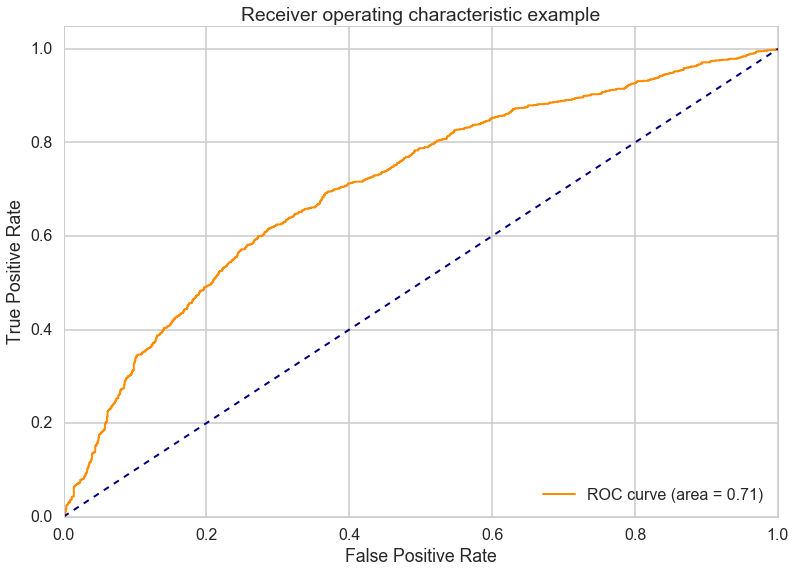

In [25]:
plt.plot(fpr, tpr, color='darkorange',
         lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")

In [26]:
clf_l.coef_

array([[-0.01241028,  0.70935933,  0.01496119,  0.00531371]])

In [27]:
clf_l.intercept_

array([ 2.54643452])

In [28]:
print(clf_l.get_params)

<bound method BaseEstimator.get_params of LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)>


#### Odd Ratio for coefficients clf_1.coef_ and intercept

In [33]:
print(np.exp(-0.01241028))
print(np.exp(0.70935933))
print(np.exp(0.01496119))
print(np.exp(0.00531371))
#and intercept
print(np.exp(2.54643452))

0.987666409949
2.03268855881
1.01507366884
1.0053278528
12.7615216197
